<a href="https://colab.research.google.com/github/fatsed/CustomerSupportToneChecker/blob/main/notebooks/02_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building a Tone Classification Model -> ساخت مدل تشخیص لحن



1.  Text cleaning with Hazm
2. Text to vector conversion with TF-IDF
1.   Training an SVM model
2.   Evaluating the model (accuracy, F1-score, confusion matrix)
1.   Saving the model as a pickle
2.   Saving the TF-IDF vectorizer=
1.  Saving the label encoder







#cleanning with hazm

In [ ]:
!pip install gensim python-crfsuite fasttext flashtext && pip install hazm --no-deps

In [ ]:
!git clone https://github.com/fatsed/CustomerSupportToneChecker.git

fatal: destination path 'CustomerSupportToneChecker' already exists and is not an empty directory.


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/CustomerSupportToneChecker/dataset/tone_dataset.csv")
df.head(), df.shape

(  id                                               text   label
 0  1  سلام وقت بخیر. می‌خواستم وضعیت سفارش شماره ۱۲۳...  polite
 1  2  سلام و عرض ادب. لطفاً زمان تقریبی ارسال بسته م...  polite
 2  3  با سلام. ممنون می‌شم اگر کد رهگیری را برای بند...  polite
 3  4  روزتون بخیر. امکانش هست وضعیت مرسوله را بررسی ...  polite
 4  5  سلام. ممنون می‌شم اگر راهنمایی کنید چطور می‌تو...  polite,
 (300, 3))

In [ ]:
import re
from hazm import Normalizer, word_tokenize, Stemmer, Lemmatizer
from hazm import stopwords_list

normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()

# STOPWORDS
custom_stopwords = {
    "خیلی", "واقعا", "لطفا", "لطفاً", "اگر", "اگه", "یه", "یکم",
    "مثلا", "یعنی", "خب", "باشه", "اوکی", "اصلا", "اصلاً", "چیزی"
}
stopwords = set(stopwords_list()) | custom_stopwords

# Arabic → Persian (correct direction)
ARABIC_TO_PERSIAN = {
    "ي": "ی",
    "ى": "ی",
    "ئ": "ی",
    "ك": "ک",
    "ة": "ه",
    "ۀ": "ه",
    "ؤ": "و",
    "أ": "ا",
    "إ": "ا",
}

def arabic_to_persian(text):
    for ar, pe in ARABIC_TO_PERSIAN.items():
        text = text.replace(ar, pe)
    return text

# Stretch (عاااالی → عالی)
def remove_stretch(text):
    return re.sub(r"(.)\1+", r"\1", text)

# SLANG dictionary (colloquial → formal)
SLANG = {
    "می‌خواهم": "میخوام",
    "می‌خواهی": "میخوای",
    "می‌خواهد": "میخواد",
    "می‌خواهند": "میخوان",
    "می‌روی": "میری",
    "می‌رویم": "میریم",
    "چه کار":"چیکار",
    "چگونه": "چجوری",
    "چگونه": "چطور",
    "ندارید": "ندارین",
    "دارید": "دارین",
    "فکر": "فک",
}

def slang_normalizer(text):
    for s, f in SLANG.items():
        text = text.replace(s, f)
    return text

# Noise remove
def remove_noise(text):
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[@#]\w+", " ", text)
    text = re.sub(r"[^\w\s\u0600-\u06FF]", " ", text)
    return text

# Main clean function
def clean_text(text):

    text = re.sub(r"<.*?>", " ", text)
    text = normalizer.normalize(text)
    text = arabic_to_persian(text)
    text = slang_normalizer(text)
    text = remove_stretch(text)
    text = remove_noise(text)

    text = re.sub(r"[0-9۰-۹]+", " ", text)
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)

    tokens = [t for t in tokens if len(t) > 2]
    tokens = [t for t in tokens if t not in stopwords]

    # NO stemmer, NO lemmatizer — they break polite/semi/impolite
    # tokens = [lemmatizer.lemmatize(t) for t in tokens]
    # tokens = [stemmer.stem(t) for t in tokens]

    tokens = [t for t in tokens if re.match(r"^[آ-ی]+$", t)]

    return " ".join(tokens)

# apply
df["clean"] = df["text"].apply(clean_text)
df.head()

,id,text,label,clean
0,1,سلام وقت بخیر. می‌خواستم وضعیت سفارش شماره ۱۲۳...,polite,سلام وقت بخیر خواستم وضعیت سفارش شماره بدونم
1,2,سلام و عرض ادب. لطفاً زمان تقریبی ارسال بسته م...,polite,سلام عرض ادب زمان تقریبی ارسال بسته منو اعلام
2,3,با سلام. ممنون می‌شم اگر کد رهگیری را برای بند...,polite,سلام منون رهگیری بنده ارسال
3,4,روزتون بخیر. امکانش هست وضعیت مرسوله را بررسی ...,polite,روزتون بخیر امکانش هست وضعیت مرسوله برسی
4,5,سلام. ممنون می‌شم اگر راهنمایی کنید چطور می‌تو...,polite,سلام منون راهنمای چطور تونم آدرس اصلاح


In [ ]:
print(clean_text("این چه وضعشه؟ بسته‌م چرا اینقدر دیر رسید؟"))
print(clean_text("سلام وقت بخیر، میشه وضعیت سفارشم رو بگید؟"))

وضعشه بسته اینقدر دیر
سلام وقت بخیر میشه وضعیت سفارشم بگید


In [ ]:
from sklearn.preprocessing import LabelEncoder
# y = متنِ لیبل‌ها (polite / semi_polite / impolite)
y_text = df["label"]
le = LabelEncoder()
y = le.fit_transform(y_text)
print(dict(zip(le.classes_, range(len(le.classes_)))))

{'impolite': 0, 'polite': 1, 'semi_polite': 2}


#train and test


In [ ]:
from sklearn.model_selection import train_test_split
X = df["clean"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 240
Test size: 60


#TF-IDF + SVM

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="word",
        ngram_range=(1, 2),
        max_features=7000,
        min_df=2
    )),
    ("svm", LinearSVC(
        C=1.0,
        class_weight="balanced"
    ))
])
pipeline.fit(X_train, y_train)
print("✅ مدل آموزش دید.")

✅ مدل آموزش دید.


#Model evaluation

Accuracy: 0.85

Classification report:

              precision    recall  f1-score   support

    impolite       0.89      0.85      0.87        20
      polite       0.83      1.00      0.91        20
 semi_polite       0.82      0.70      0.76        20

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



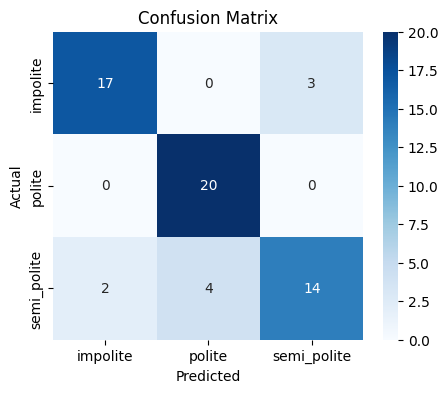

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import pickle, os
os.makedirs("../model", exist_ok=True)
with open("../model/tone_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)
with open("../model/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
print("✅ مدل و label encoder ذخیره شد توی پوشه ../model")


✅ مدل و label encoder ذخیره شد توی پوشه ../model


In [ ]:
def predict_tone(text):
    cleaned = clean_text(text)
    label_num = pipeline.predict([cleaned])[0]
    return le.inverse_transform([label_num])[0]

samples = [
    "سلام وقت بخیر، میشه وضعیت سفارشم رو بگید؟",
    "چند روزه سفارشم رو نفرستادین، واقعا ناراحتم.",
    "این چه وضعشه؟ چرا هیچکس جواب درست نمی‌ده؟"
]

for s in samples:
    print(s, "  →  ", predict_tone(s))

سلام وقت بخیر، میشه وضعیت سفارشم رو بگید؟   →   polite
چند روزه سفارشم رو نفرستادین، واقعا ناراحتم.   →   impolite
این چه وضعشه؟ چرا هیچکس جواب درست نمی‌ده؟   →   impolite
